In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import json
import ast

In [333]:
assets = set(f.split('USD')[0] for f in os.listdir('data') if f.endswith('.csv') and 'USD' in f)

In [334]:
assets

{'BTA', 'GMMA', 'LMDA', 'ZTA'}

Collect and visualize data

In [335]:
trades = {}
mkt_data_raw = {}
trades_data_raw = {}

for asset in assets:

    with open(f'data/{asset}USD.json') as f:
        d = json.load(f)
        tick_size = d['tick_size'] 



    df_mkt = pd.read_csv(f'data/{asset}USD_md.csv', index_col=0)
    df_mkt.index = pd.to_datetime(df_mkt.index, unit = 'ms')

    for col in df_mkt.columns:
        df_mkt[col] = np.round(df_mkt[col] / tick_size) * tick_size


    df_mkt['mid'] = .5 * (df_mkt.ask + df_mkt.bid) 
    df_mkt['spread'] = df_mkt.ask - df_mkt.bid

    mkt_data_raw[asset] = df_mkt
    
    df_trades = pd.read_csv(f'data/{asset}USD_trades.csv', index_col=0)
    df_trades.index = pd.to_datetime(df_trades.index, unit = 'ms')
    df_trades.sort_index(inplace=True)
    df_trades.px = np.round(df_trades.px / tick_size) * tick_size
    trades_data_raw[asset] = df_trades

    df_trades_vs_mkt = pd.merge_asof(left = df_mkt,
                                     right= df_trades[['trade_id', 'side', 'size', 'px']],
                                     left_index = True,
                                     right_index=True,
                                     direction = 'backward'
                                     )
    
    trades[asset] = df_trades_vs_mkt

/var/folders/90/n6hg0h0d3bx5861ysywz0rj00000gn/T/ipykernel_6143/2528756274.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


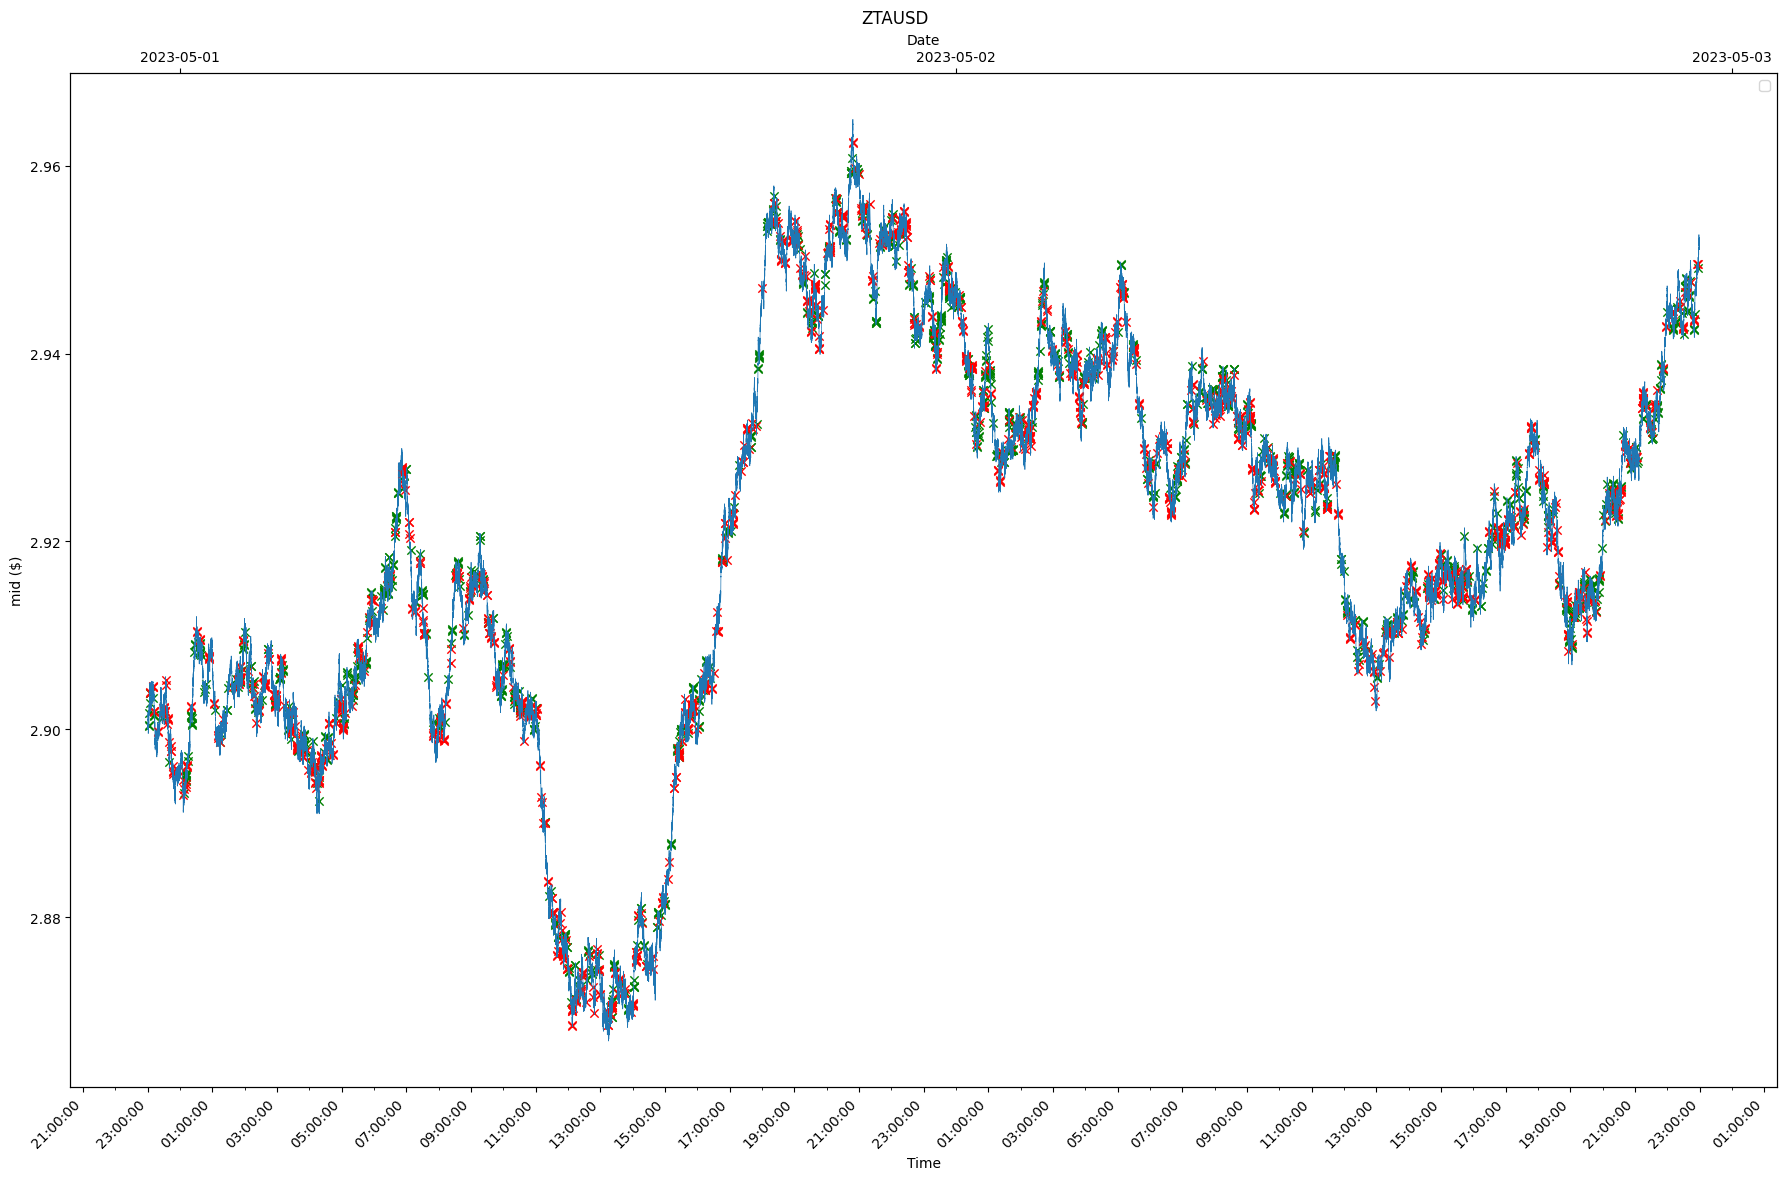

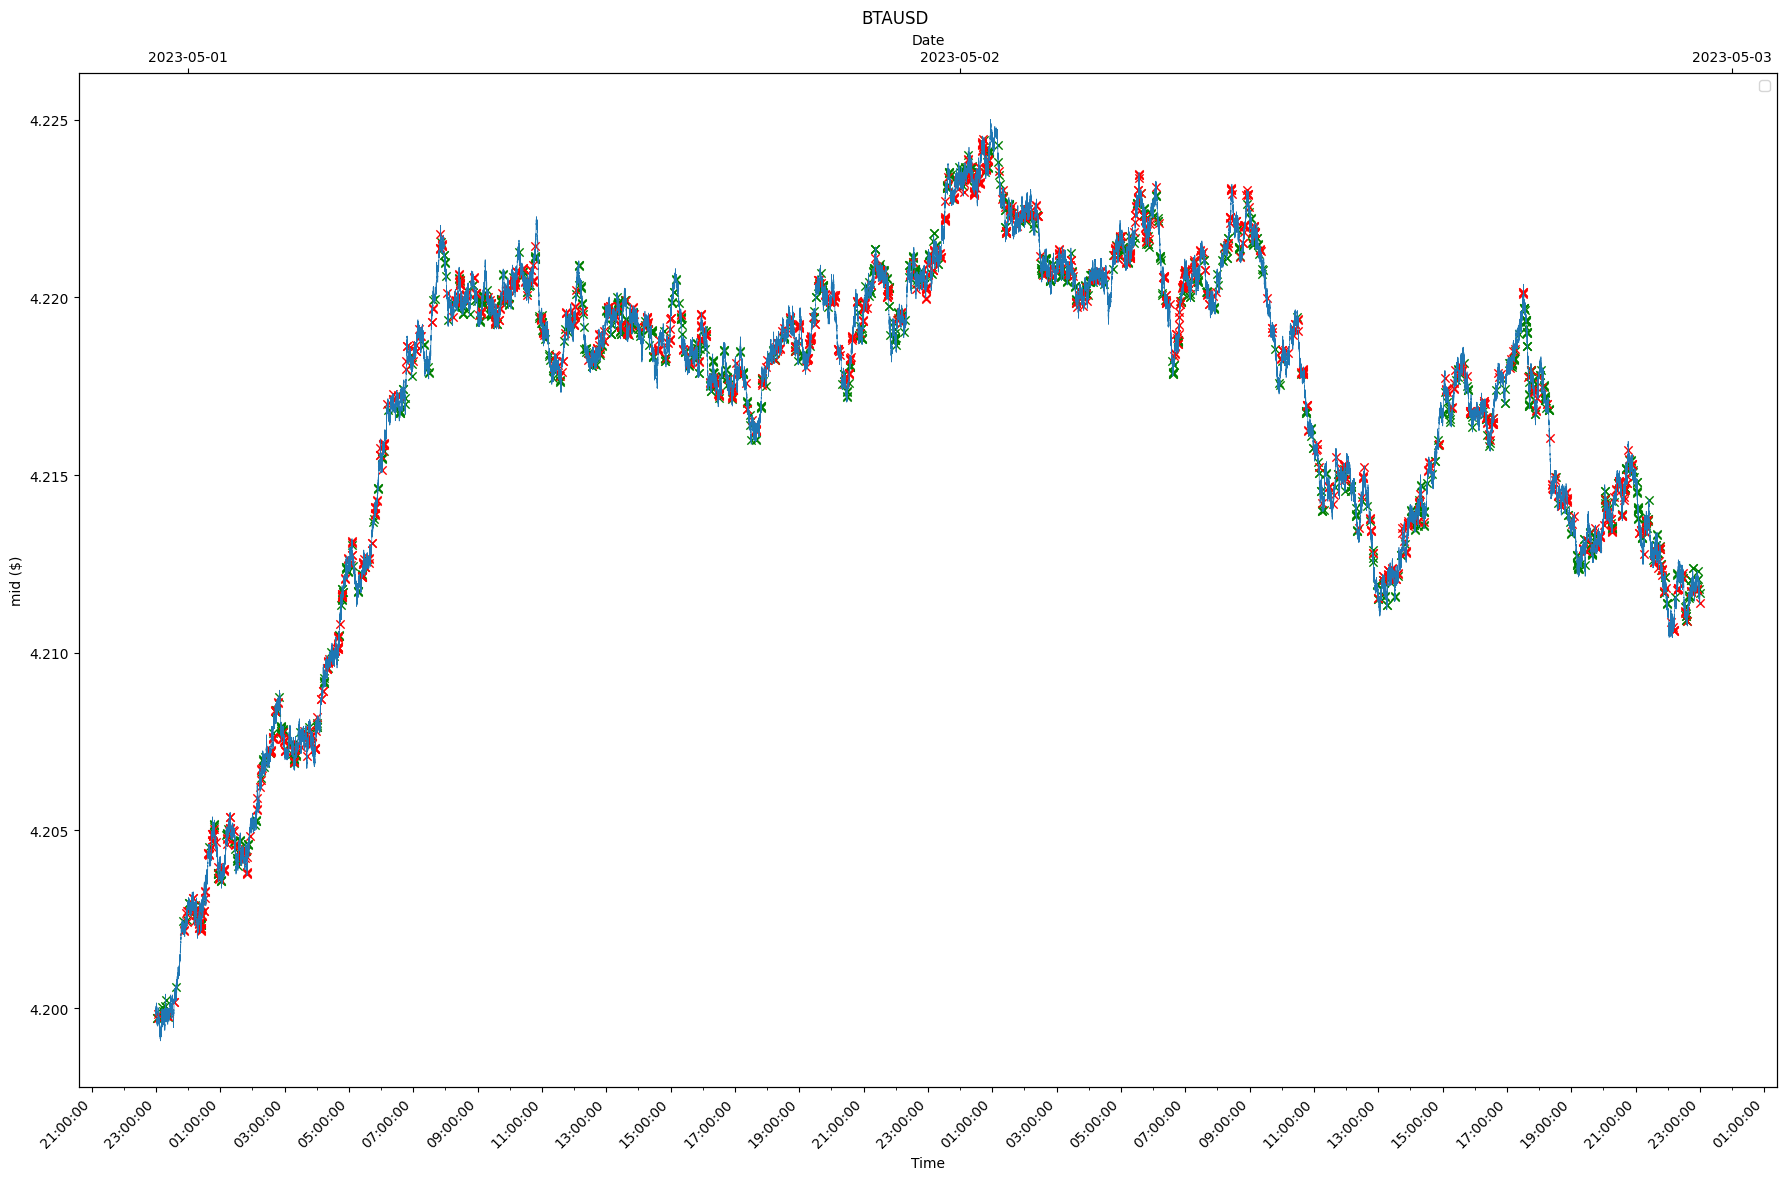

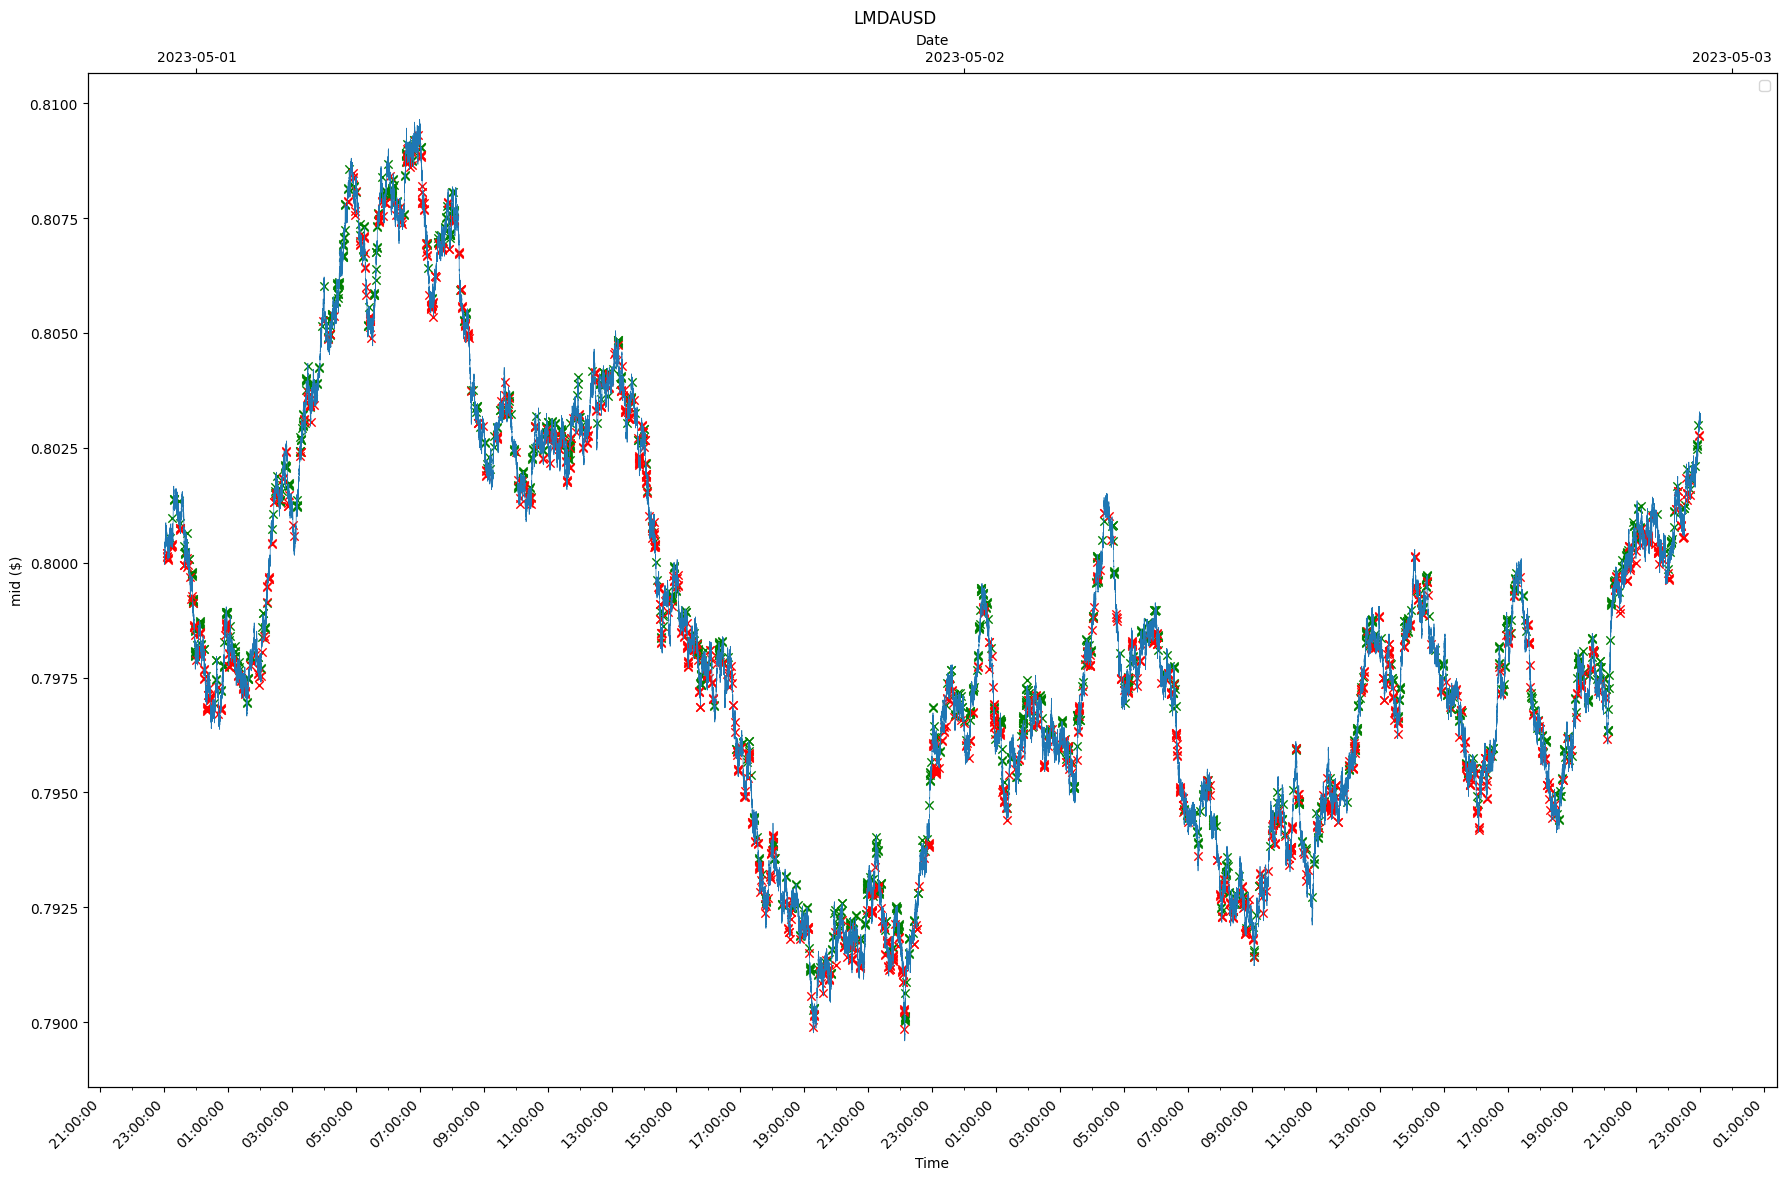

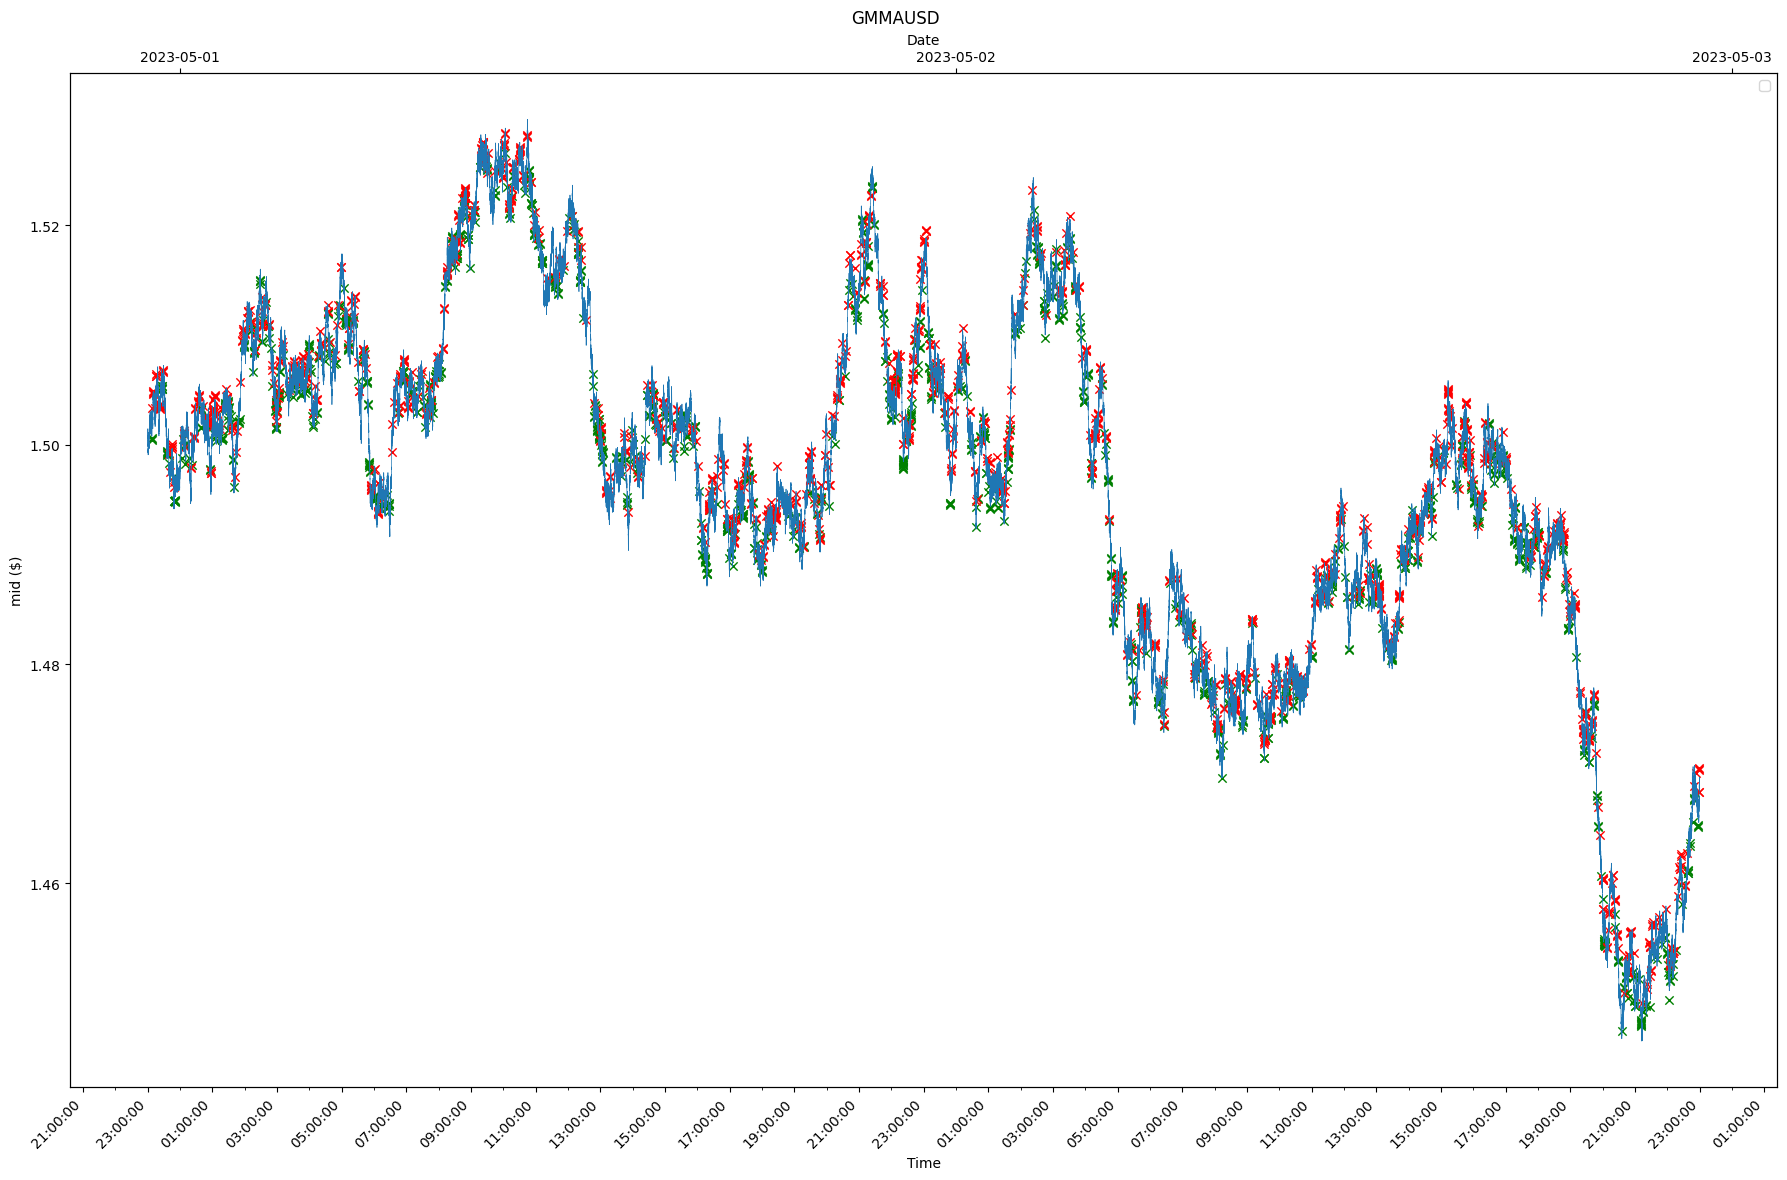

In [336]:
for asset, df in trades.items():
    fig, axs = plt.subplots(figsize=(18, 12))
    fig.suptitle(f'{asset}USD')
    
    axs.plot(df.index, df.mid, linewidth=.5)

    buys = df[df.side == 'B'].drop_duplicates('trade_id')
    sells = df[df.side == 'S'].drop_duplicates('trade_id')

    axs.scatter(buys.index, buys.px, color='green', marker='x',
                label='buy', linewidth=1)
    
    axs.scatter(sells.index, sells.px, color='red', marker='x',
                label='sell', linewidth=1)

    axs.set_ylabel('mid ($)')
    
    # Configure bottom x-axis (primary) to show time
    axs.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Every 2 hours
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs.xaxis.set_minor_locator(mdates.HourLocator(interval=1))  # Minor ticks every hour
    axs.set_xlabel('Time')
    
    # Add top x-axis for date only
    ax2 = axs.twiny()
    ax2.set_xlim(axs.get_xlim())  # Match the primary axis range
    ax2.xaxis.set_major_locator(mdates.DayLocator())  # Every day
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.set_xlabel('Date')
    
    # Rotate the time labels at the bottom for better readability
    plt.setp(axs.get_xticklabels(), rotation=45, ha='right')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

Per asset analysis

In [337]:
def hourly_plot(df: pd.DataFrame, start: str, end: str, asset: str):

    df_zoom = df[(df.index > start ) & (df.index < end )]

    fig, axs = plt.subplots(figsize=(15, 10))
    fig.suptitle(f'{asset}USD')

    #axs.plot(df_zoom.index, df_zoom.mid, linewidth=.5)
    axs.plot(df_zoom.index, df_zoom.bid, linewidth=.25, label = 'bid', color = 'tan')
    axs.plot(df_zoom.index, df_zoom.ask, linewidth=.25, label = 'ask', color = 'grey')

    buys = df_zoom[df_zoom.side == 'B'].drop_duplicates('trade_id')
    sells = df_zoom[df_zoom.side == 'S'].drop_duplicates('trade_id')

    axs.scatter(buys.index, buys.px, color='green', marker='x',
                label='buy', linewidth=2)

    axs.scatter(sells.index, sells.px, color='red', marker='x',
                label='sell', linewidth=2)

    axs.set_ylabel('mid ($)')
 
    hours = mdates.HourLocator()
    minutes = mdates.MinuteLocator(byminute=[0, 15, 30, 45]) 
    hours_fmt = mdates.DateFormatter('%H:%M:%S')

    date_str = df_zoom.index[0].strftime('%Y-%m-%d')
    plt.xlabel(f'Time (Date: {date_str})')

    axs.xaxis.set_major_locator(hours)
    axs.xaxis.set_major_formatter(hours_fmt)
    axs.xaxis.set_minor_locator(minutes)

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [338]:
with open('data/horizon_ticks', 'r') as f:
    ticks_str = f.read()
    ticks = ast.literal_eval(ticks_str)

In [339]:
def synch_horizons_and_market_prices(df_mkt, df_trades, horizons):
    
    market_data = df_mkt.copy()
    trades = df_trades.copy()
    
    
    trades = trades.reset_index().rename(columns={'ts_ms': 'trade_time'})
    market_data = market_data.reset_index().rename(columns={'ts_ms': 'timestamp'})
    
    
    horizon_dfs = []
    
    for horizon in horizons:
        horizon_df = trades.copy()
        
        horizon_df['target_time'] = horizon_df['trade_time'] + pd.Timedelta(milliseconds=horizon)
        
        horizon_df['horizon'] = horizon
        
        horizon_dfs.append(horizon_df)
    
    
    all_horizons = pd.concat(horizon_dfs, ignore_index=True)
    
    
    all_horizons = all_horizons.sort_values('target_time')
    market_data = market_data.sort_values('timestamp')
    
    
    merged = pd.merge_asof(
        all_horizons,
        market_data,
        left_on='target_time',
        right_on='timestamp',   
        direction='forward'  # Get most recent price before target time
    )

    return merged

def markouts(trades: pd.DataFrame) -> pd.DataFrame:
    
    buy_mask = trades['side'] == 'B'
    sell_mask = trades['side'] == 'S'

    trades['raw_pnl'] = np.nan
    
    trades.loc[buy_mask, 'raw_pnl'] = trades.loc[buy_mask, 'bid'] - trades.loc[buy_mask, 'px']
    trades.loc[sell_mask, 'raw_pnl'] = trades.loc[sell_mask, 'px'] - trades.loc[sell_mask, 'ask']
    
    trades['margin'] = trades['raw_pnl'] / trades['size']  
    
    result_df = trades[['trade_id', 'horizon', 'margin']].copy()
    
    return result_df

def aggregate_margins(markouts: pd.DataFrame) -> pd.DataFrame:

    aggregates = markouts.groupby('horizon')[['margin']].mean()
    return aggregates

def get_trades_margin(mkt_data, trades_data, horizons):
    
    synched = synch_horizons_and_market_prices(mkt_data, trades_data, horizons)
    trades_markouts = markouts(synched)
    margins = aggregate_margins(trades_markouts)

    return margins

In [340]:
def plot_margin(margins: pd.DataFrame) -> pd.DataFrame:

    fig, axs = plt.subplots(figsize=(15, 10))
    fig.suptitle(f'{asset}USD margin curve')

    #axs.plot(df_zoom.index, df_zoom.mid, linewidth=.5)
    axs.plot(margins.index, margins.margin, linewidth=1, color = 'blue')
    axs.axhline(y = 0, color = 'green', linestyle = '--', linewidth = .25)
    
    axs.set_ylabel('markout / volume')
    axs.set_xlabel('horizon (ms)')

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [341]:
def strategy_pnl(trades: pd.DataFrame, mkt_data: pd.DataFrame) -> pd.DataFrame:
    
    df_trades = trades.copy()
    df_mkt_data = mkt_data.copy()
    
    df_trades = df_trades.sort_values('ts_ms')
    df_mkt_data = df_mkt_data.sort_values('ts_ms')

    pnls = pd.merge_asof(
        df_trades[['side', 'size', 'px']], 
        df_mkt_data[['bid', 'ask']],
        on = 'ts_ms',
        direction = 'forward'   
    )

    pnls.set_index('ts_ms', inplace=True)

    pnls['side'] = pnls['side'].map({'B': 1, 'S': -1})

    pnls['position'] = np.cumsum(pnls['size'].values * pnls['side'].values)

    compute_adjusted_price(pnls)

    pnls['mark_to_market'] = np.where(pnls.position >=0, 
                                      pnls.position * (pnls.bid - pnls.adjusted_price),
                                      abs(pnls.position) * (pnls.adjusted_price - pnls.ask),
                                      )
    
    conditions = [(pnls.side == 1) & (1 != np.sign(pnls.position.shift())),
                  (pnls.side == -1) & (-1 != np.sign(pnls.position.shift()))]
    
    choices = [pnls['size'] * (pnls.adjusted_price - pnls.px),
               pnls['size'] * (pnls.px - pnls.adjusted_price)]
    

    pnls['realised'] = np.select(conditions, choices, default = 0)
    
    pnls.loc[pnls.index[0], 'realised'] = 0

    pnls.realised = pnls.realised.cumsum()

    pnls['total'] = pnls.mark_to_market + pnls.realised

    return pnls

    #pnls['mark-to-ma']

def compute_adjusted_price(trades: pd.DataFrame) -> pd.DataFrame:

    trades['adjusted_price'] = trades.px.shift()


    conditions = [
        np.sign(trades.position.shift()) == trades.side,
        np.sign(trades.position.shift()) == np.sign(trades.position)
    ]

    choices = [
        (abs(trades.position.shift()) * trades.adjusted_price + 
         trades['size'] * trades.px) / abs(trades.position),
         trades.adjusted_price
    ]

    trades.adjusted_price = np.select(conditions, choices, default = trades.px)


def max_drawdown():
    pass

In [358]:
def plot_pnls(pnls: pd.DataFrame):
    fig, axs = plt.subplots(figsize=(15, 10))
    fig.suptitle(f'{asset}USD strategy PNLs')

    axs.plot(pnls.index, pnls.mark_to_market, linewidth=.5, linestyle = '--', 
             color = 'orange', label = 'mark to market')
    axs.plot(pnls.index, pnls.realised, linewidth=1, linestyle = '--', 
             color = 'red', label = 'realised')
    axs.plot(pnls.index, pnls.total, linewidth=1, 
             color = 'grey', label = 'total')
    
    axs.set_ylabel('PNL ($)')
    axs.set_xlabel('time')

    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

ZTA

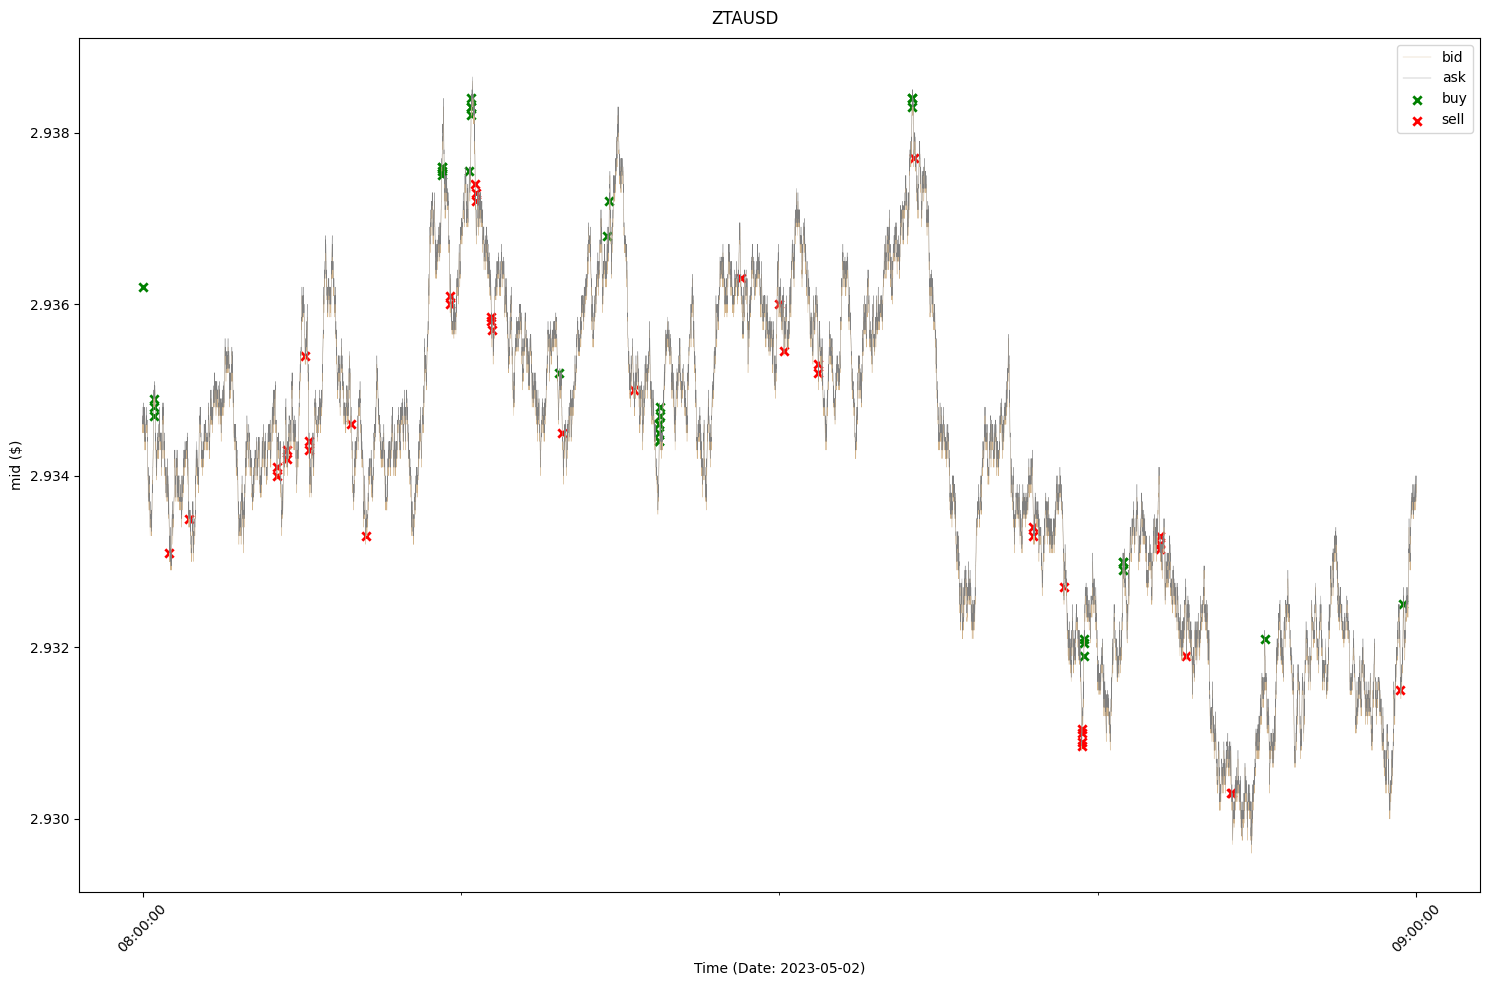

In [343]:
asset = 'ZTA'
df = trades[asset]

hourly_plot(df, '2023-05-02 8:00', '2023-05-02 9:00', asset)

/var/folders/90/n6hg0h0d3bx5861ysywz0rj00000gn/T/ipykernel_6143/1504422215.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


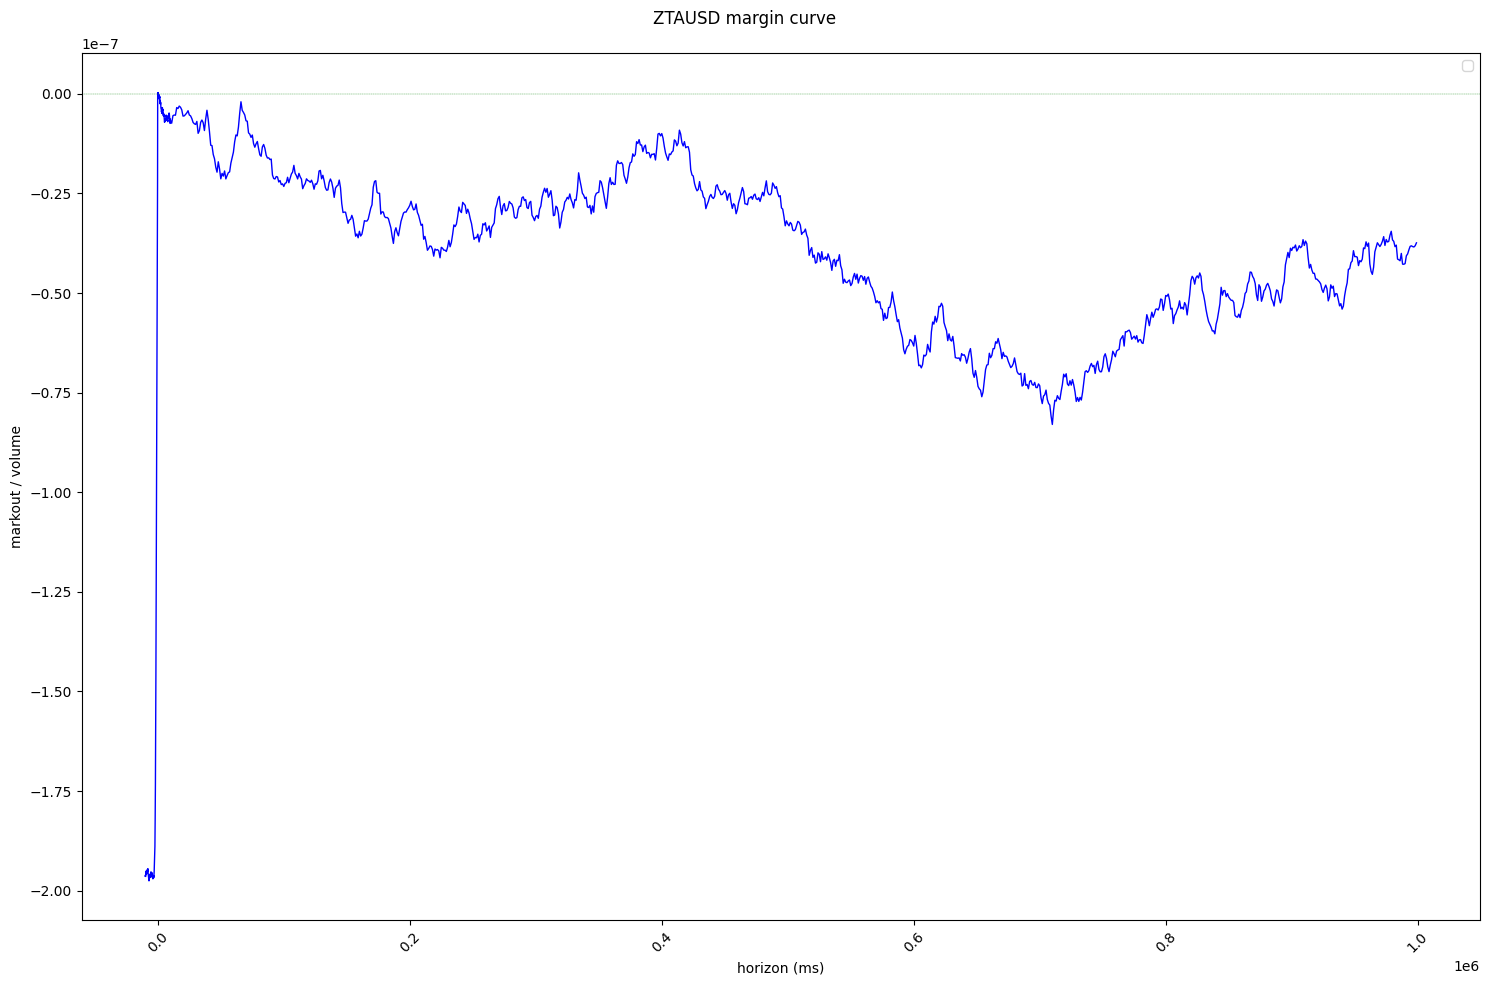

In [344]:
trades_margin = get_trades_margin(mkt_data_raw[asset], trades_data_raw[asset],ticks)
plot_margin(trades_margin)

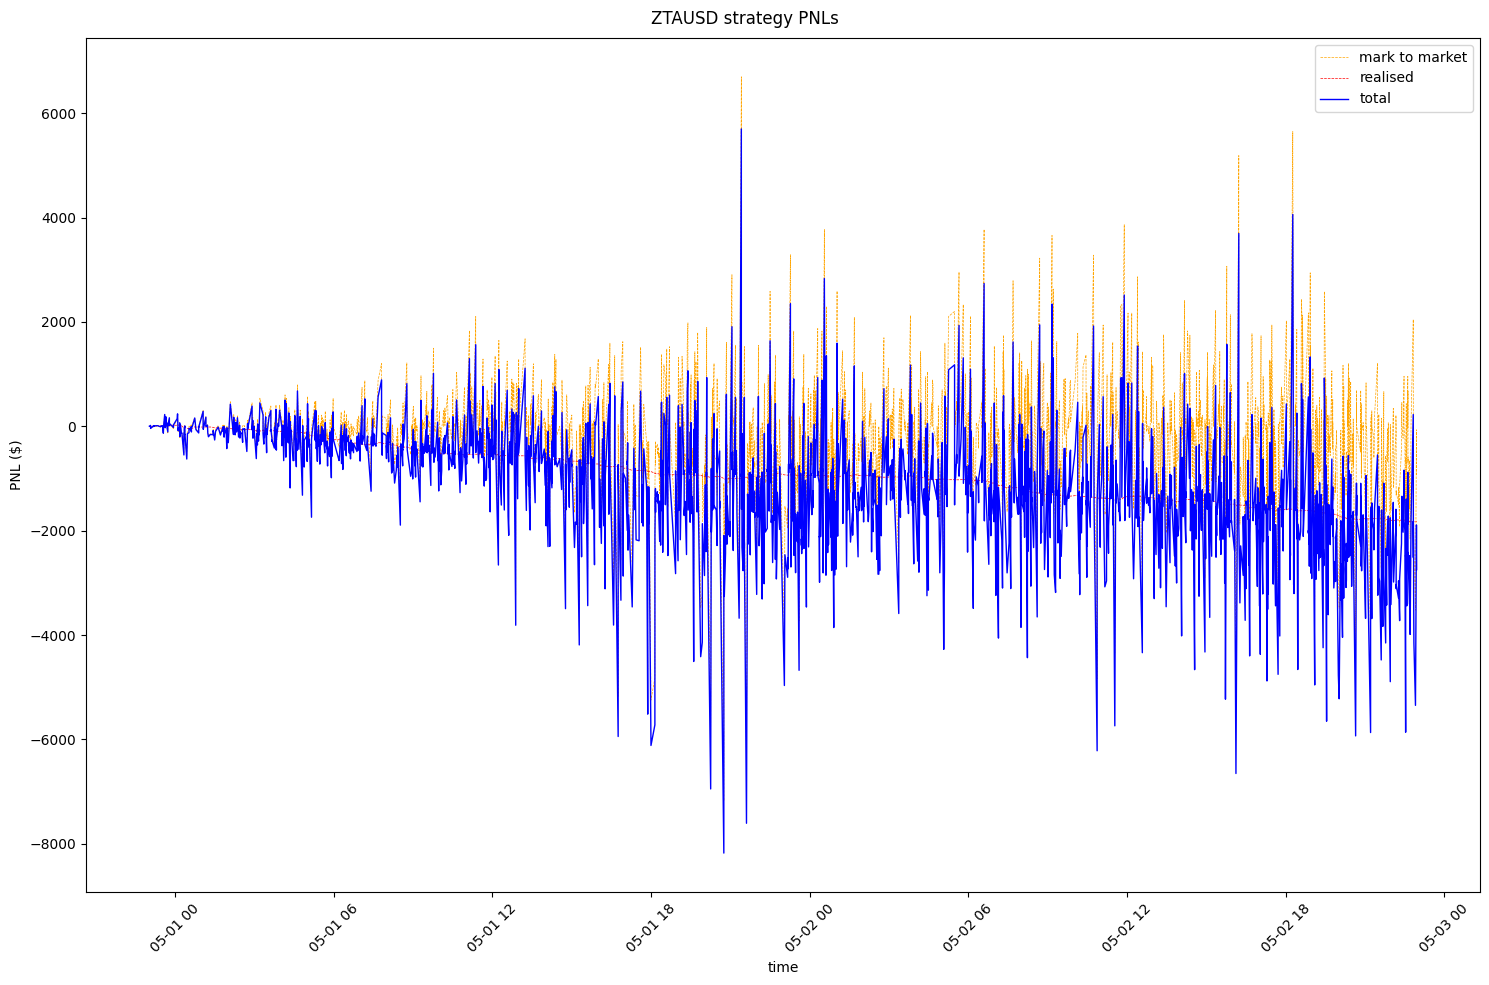

In [345]:
df = strategy_pnl(trades_data_raw[asset], mkt_data_raw[asset])
plot_pnls(df)

BTA

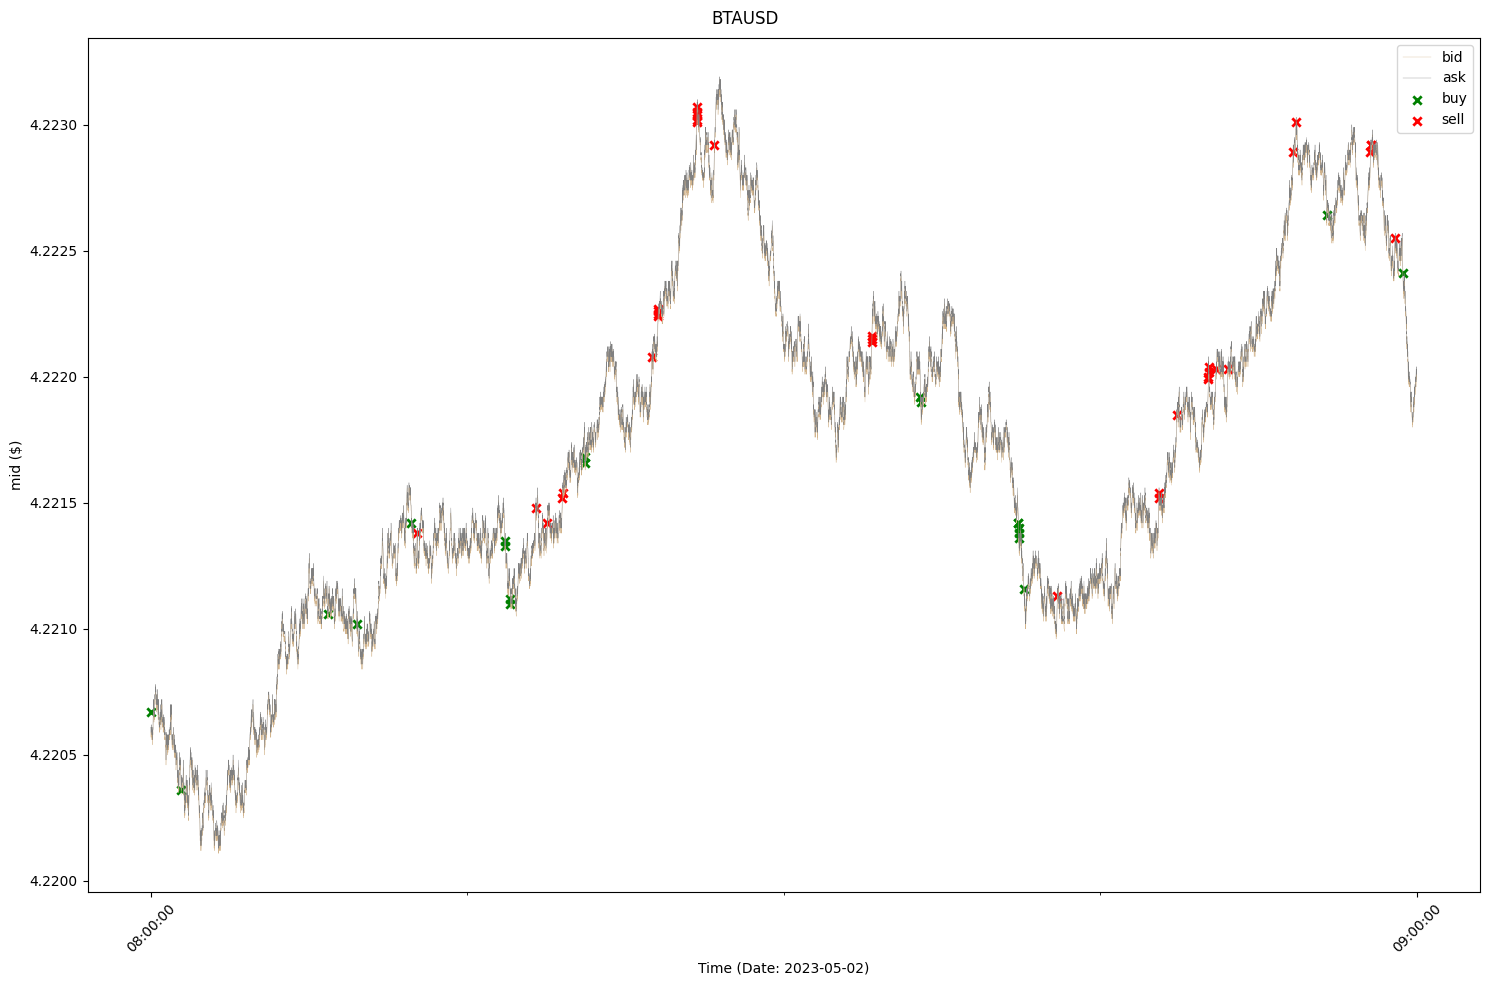

In [346]:
asset = 'BTA'
df = trades[asset]

hourly_plot(df, '2023-05-02 8:00', '2023-05-02 9:00', asset)

/var/folders/90/n6hg0h0d3bx5861ysywz0rj00000gn/T/ipykernel_6143/1504422215.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


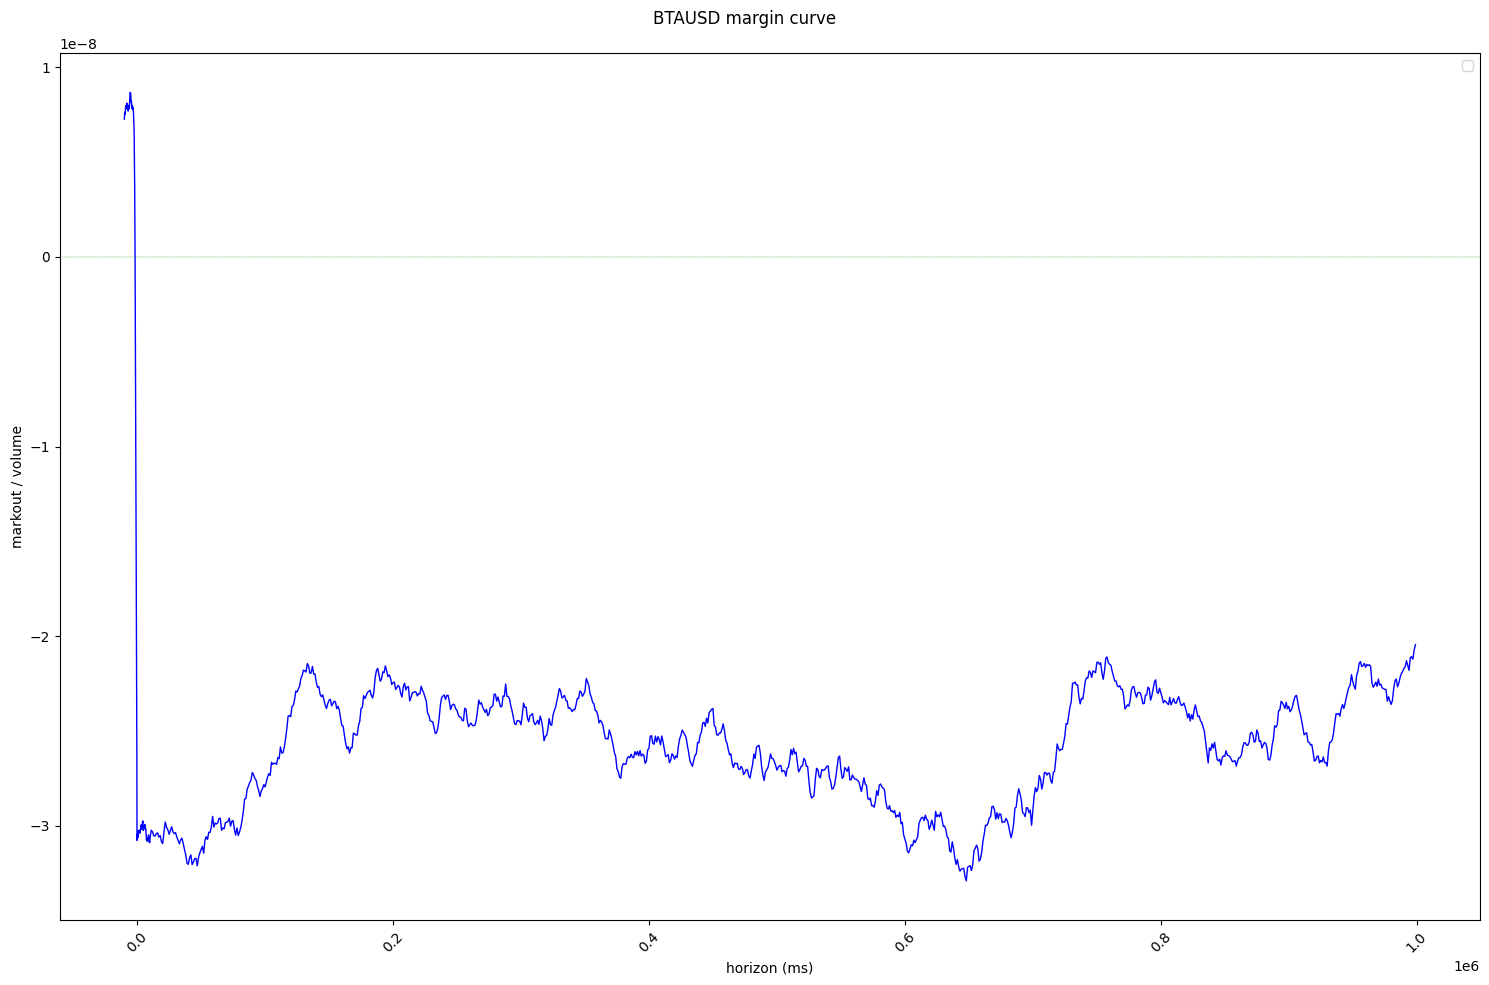

In [347]:
trades_margin = get_trades_margin(mkt_data_raw[asset], trades_data_raw[asset],ticks)
plot_margin(trades_margin)

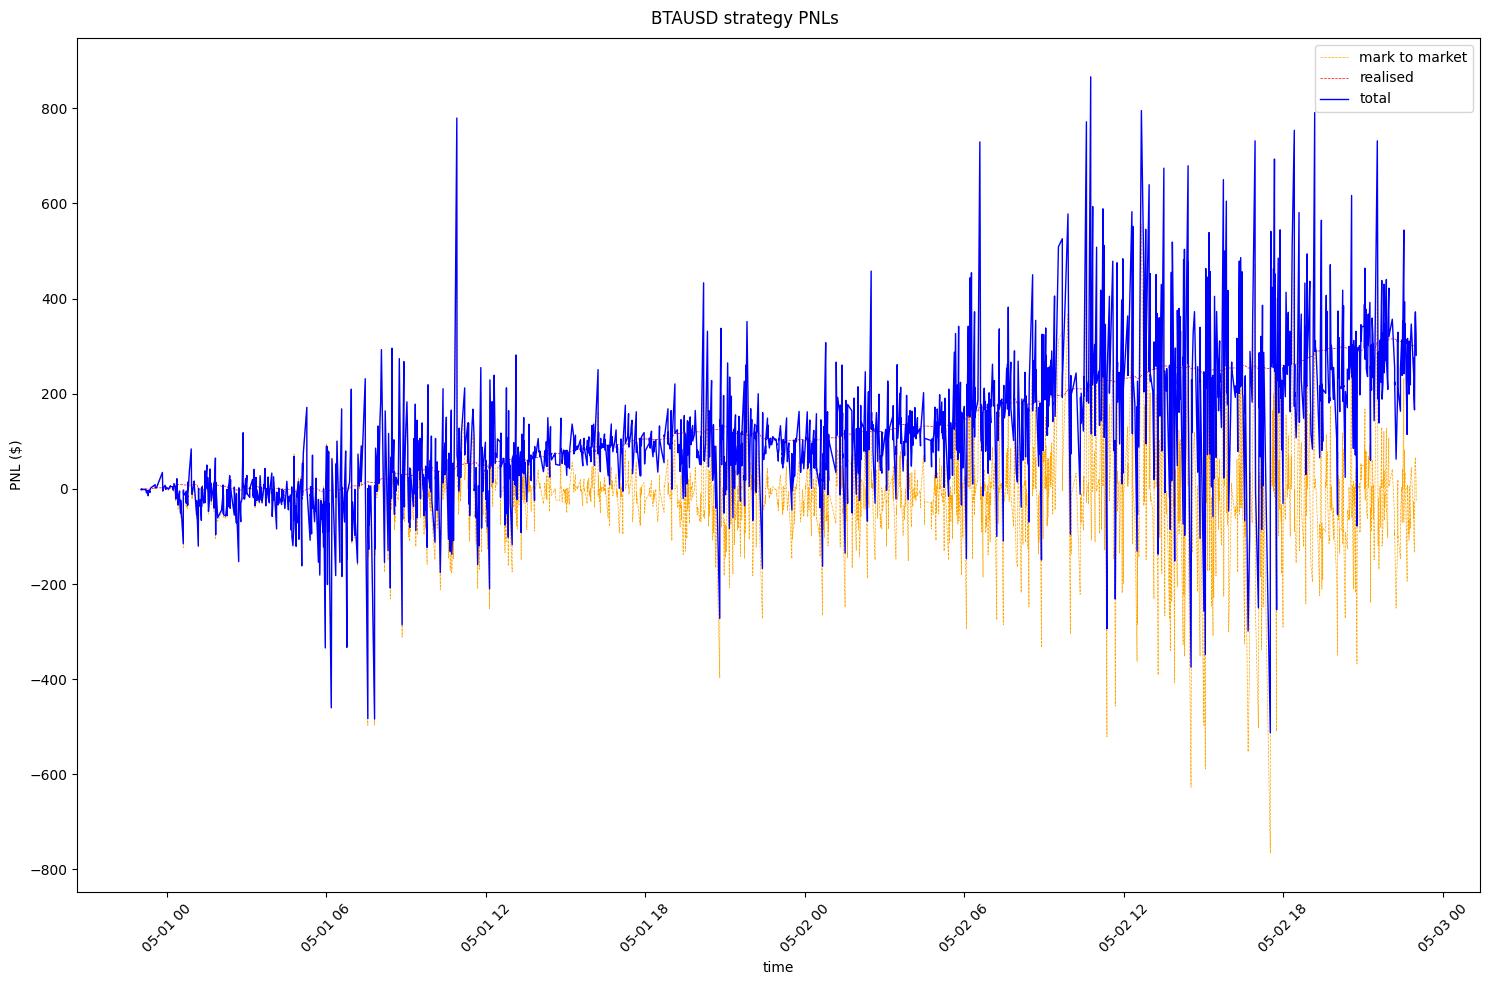

In [348]:
df = strategy_pnl(trades_data_raw[asset], mkt_data_raw[asset])
plot_pnls(df)

GMMA

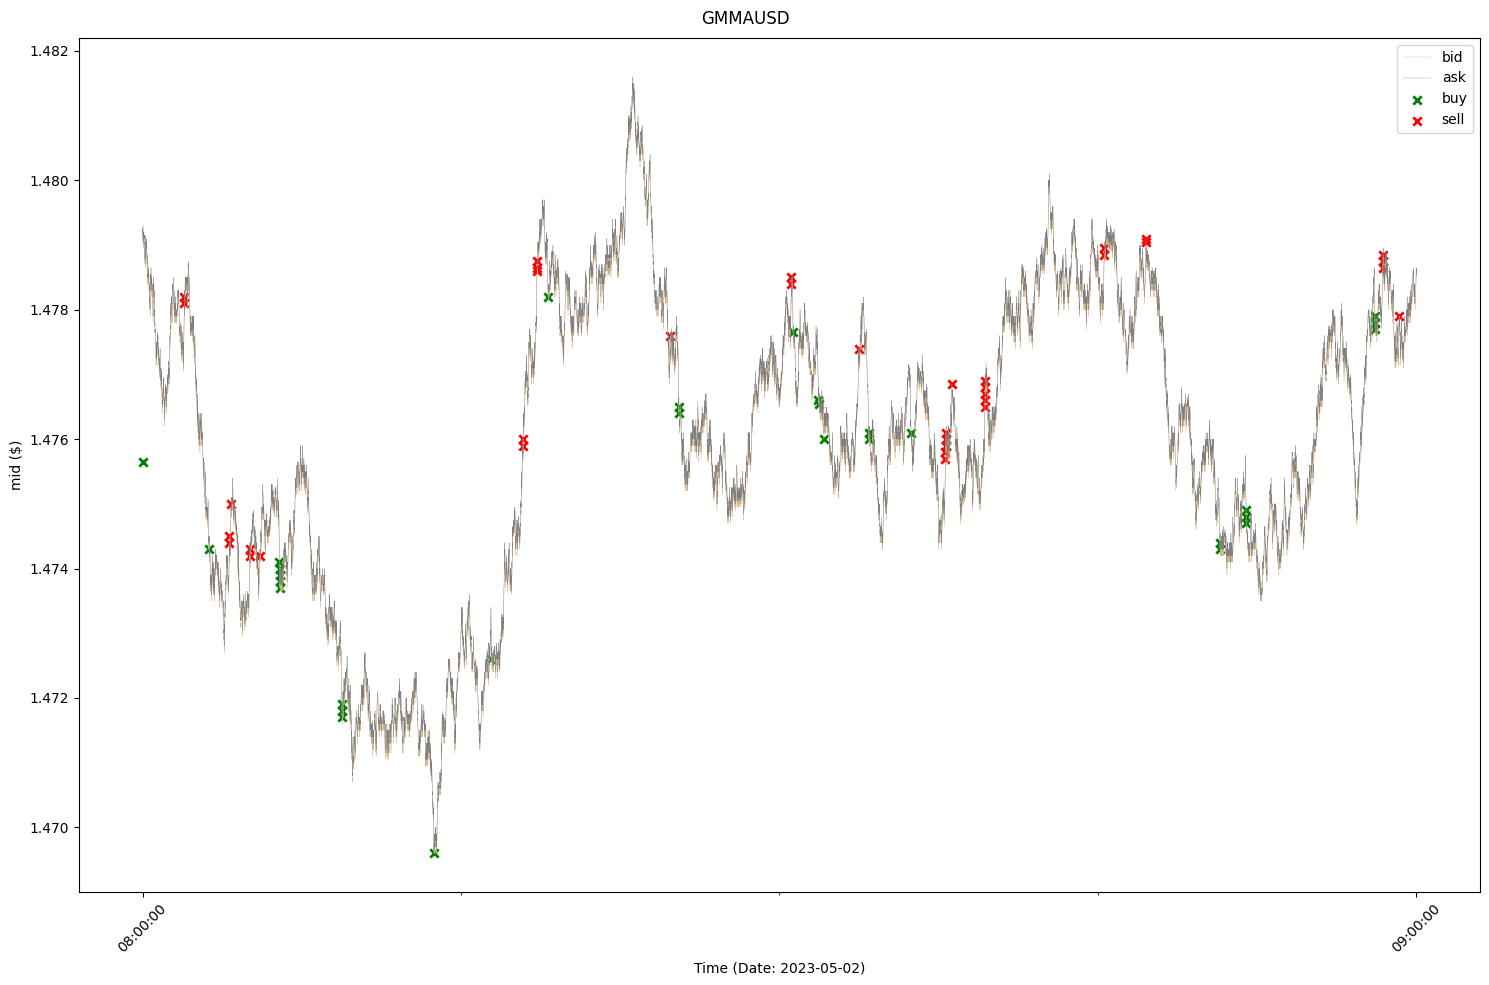

In [349]:
asset = 'GMMA'
df = trades[asset]

hourly_plot(df, '2023-05-02 8:00', '2023-05-02 9:00', asset)

/var/folders/90/n6hg0h0d3bx5861ysywz0rj00000gn/T/ipykernel_6143/1504422215.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


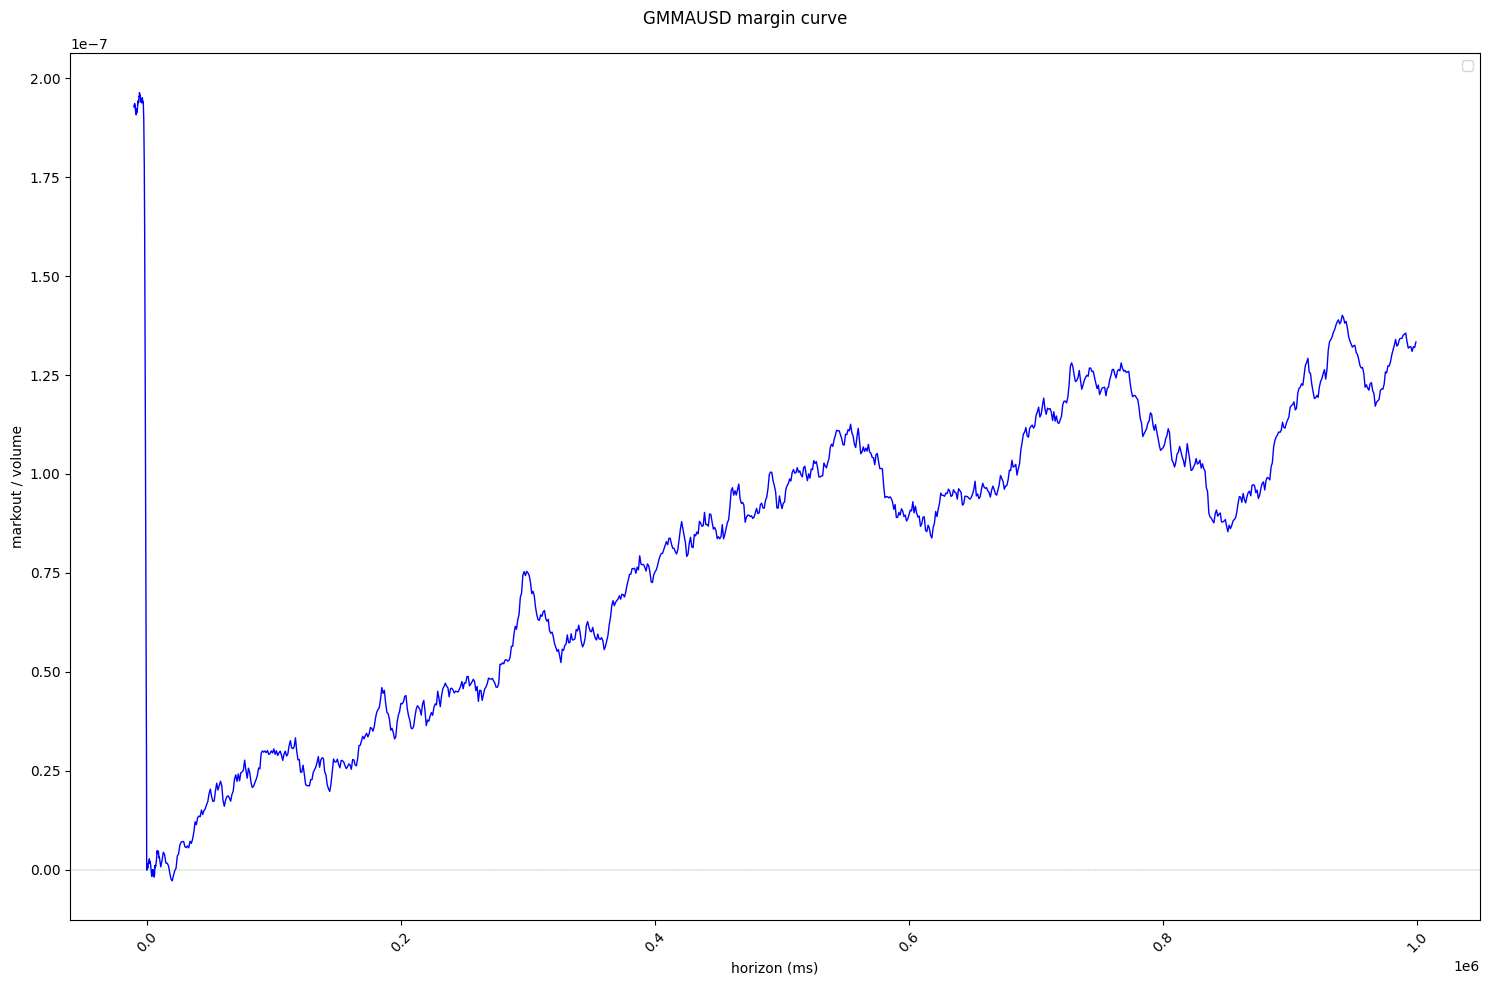

In [350]:
trades_margin = get_trades_margin(mkt_data_raw[asset], trades_data_raw[asset],ticks)
plot_margin(trades_margin)

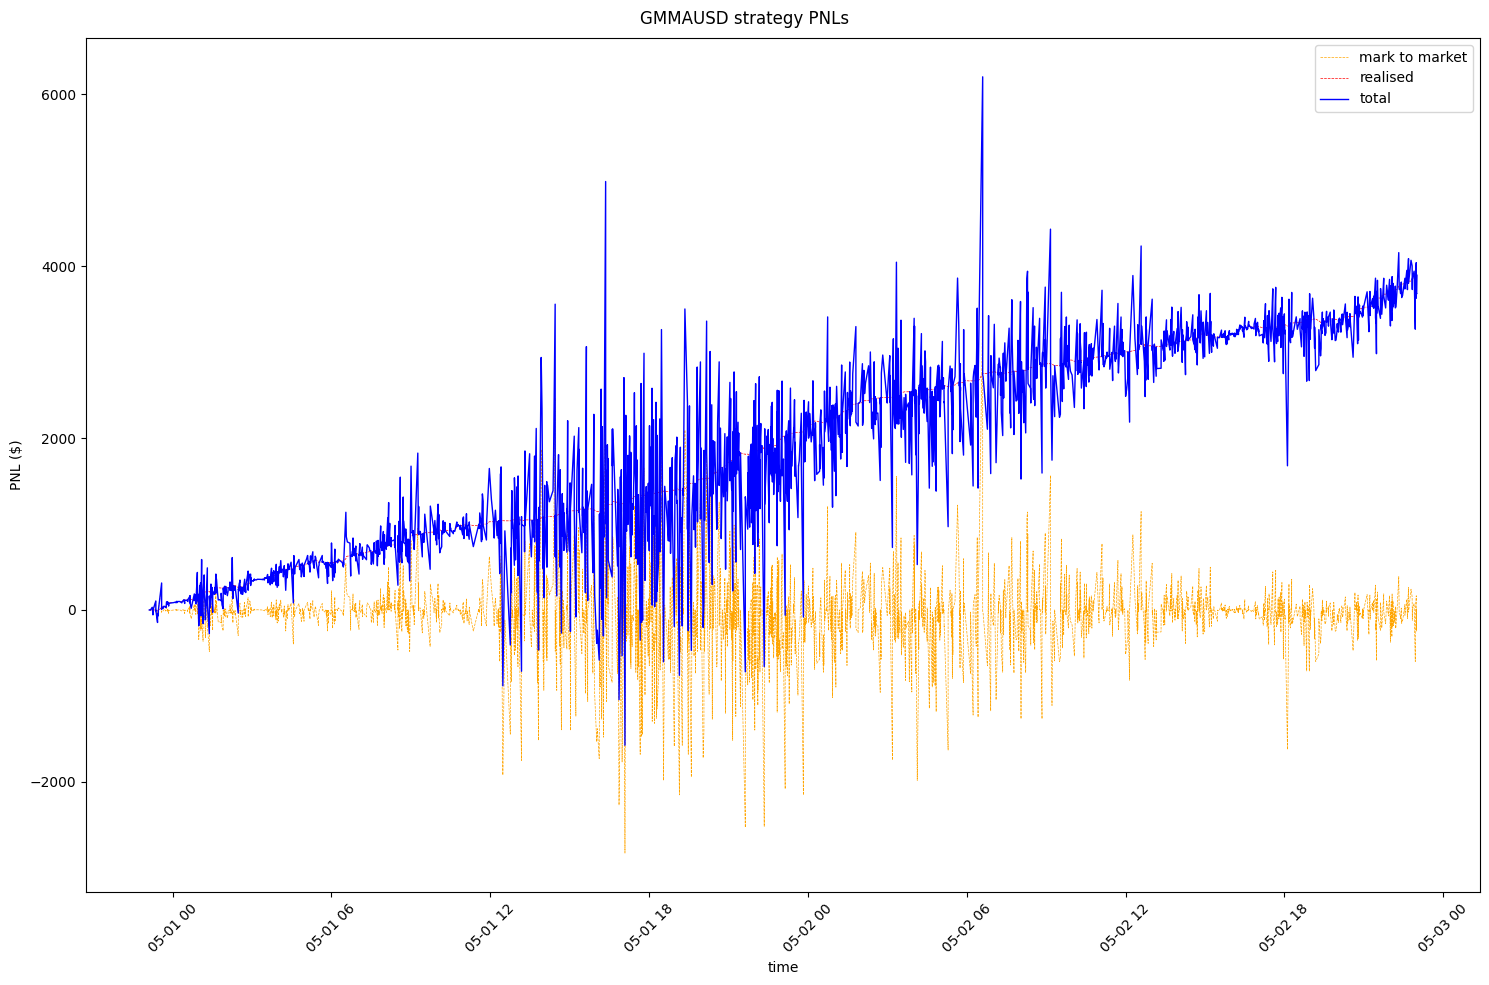

In [351]:
df = strategy_pnl(trades_data_raw[asset], mkt_data_raw[asset])
plot_pnls(df)

LMDA

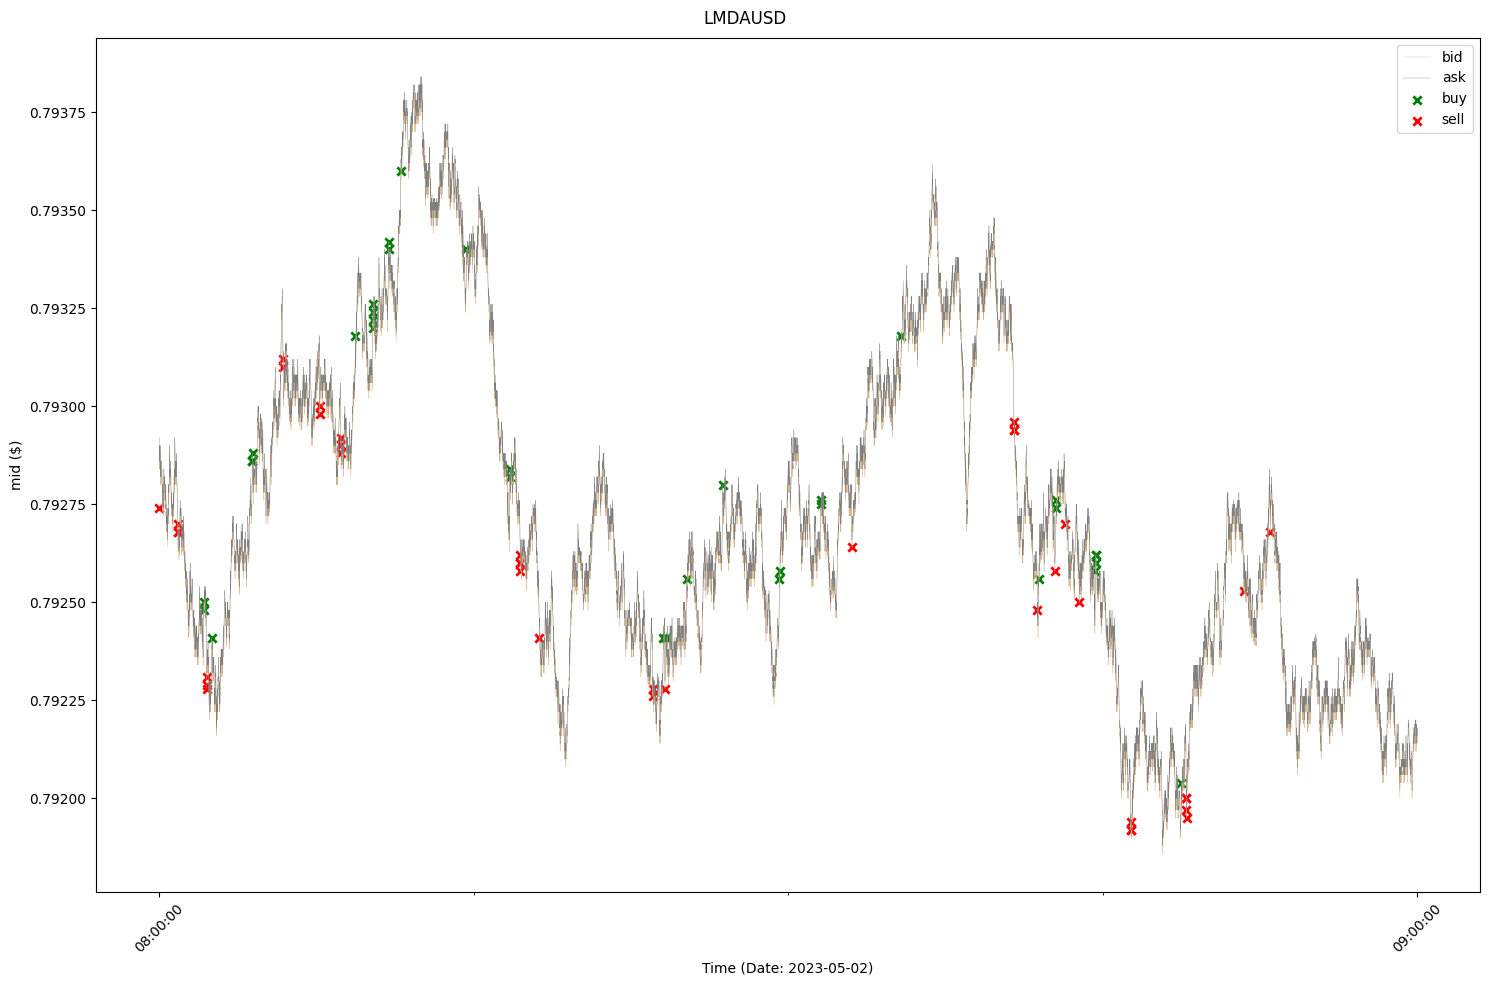

In [352]:
asset = 'LMDA'
df = trades[asset]

hourly_plot(df, '2023-05-02 8:00', '2023-05-02 9:00', asset)

/var/folders/90/n6hg0h0d3bx5861ysywz0rj00000gn/T/ipykernel_6143/1504422215.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


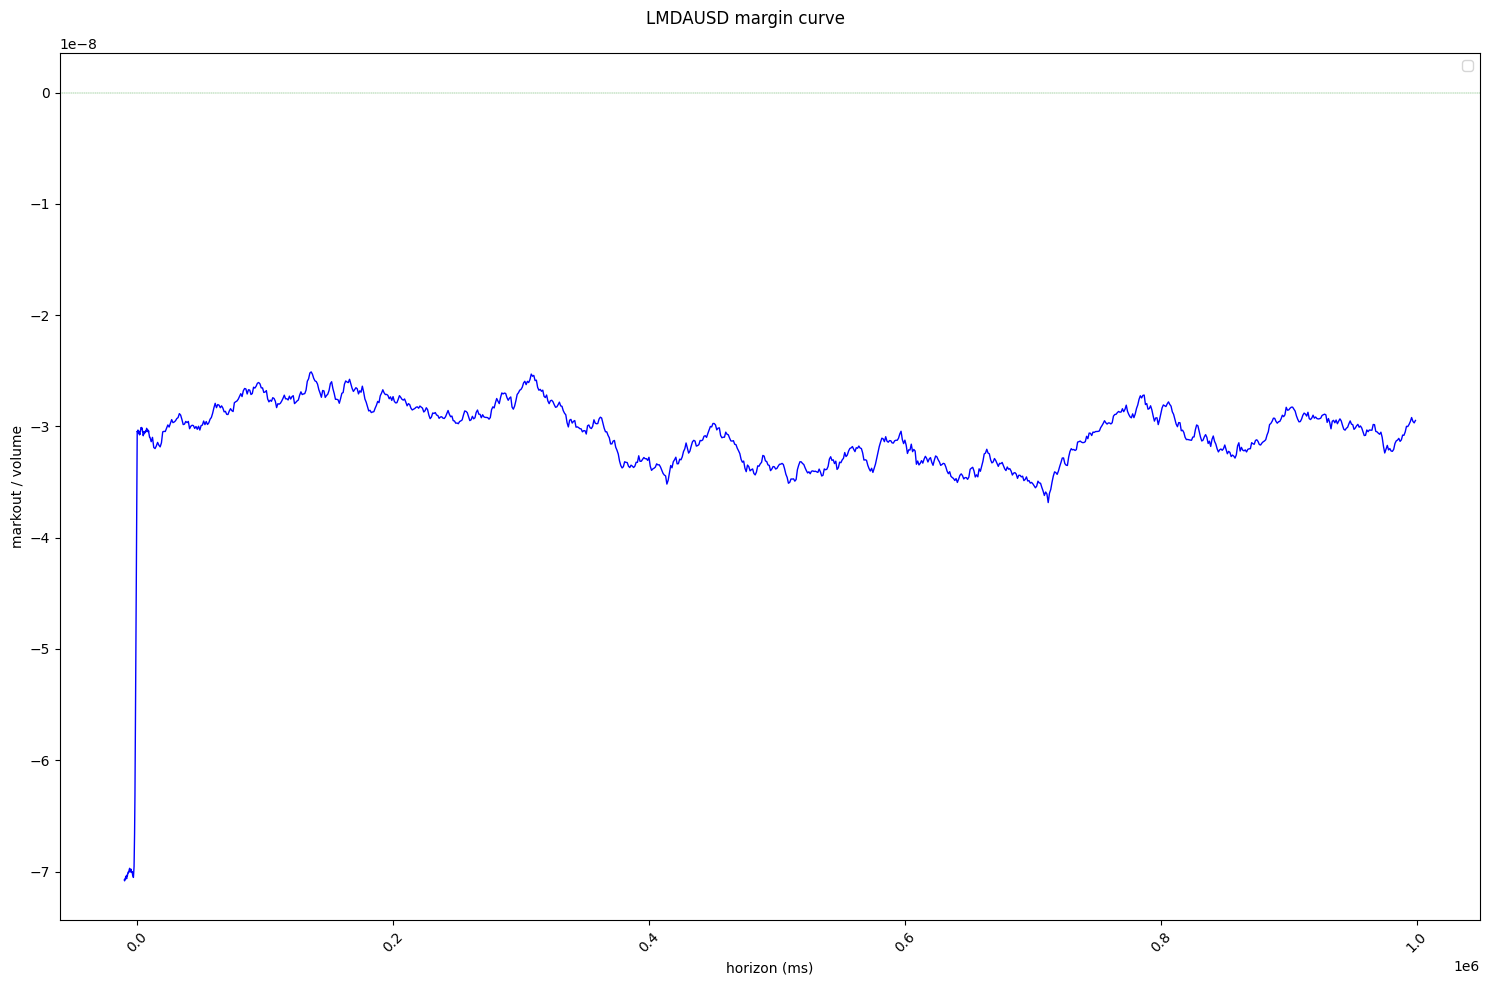

In [353]:
trades_margin = get_trades_margin(mkt_data_raw[asset], trades_data_raw[asset],ticks)
plot_margin(trades_margin)

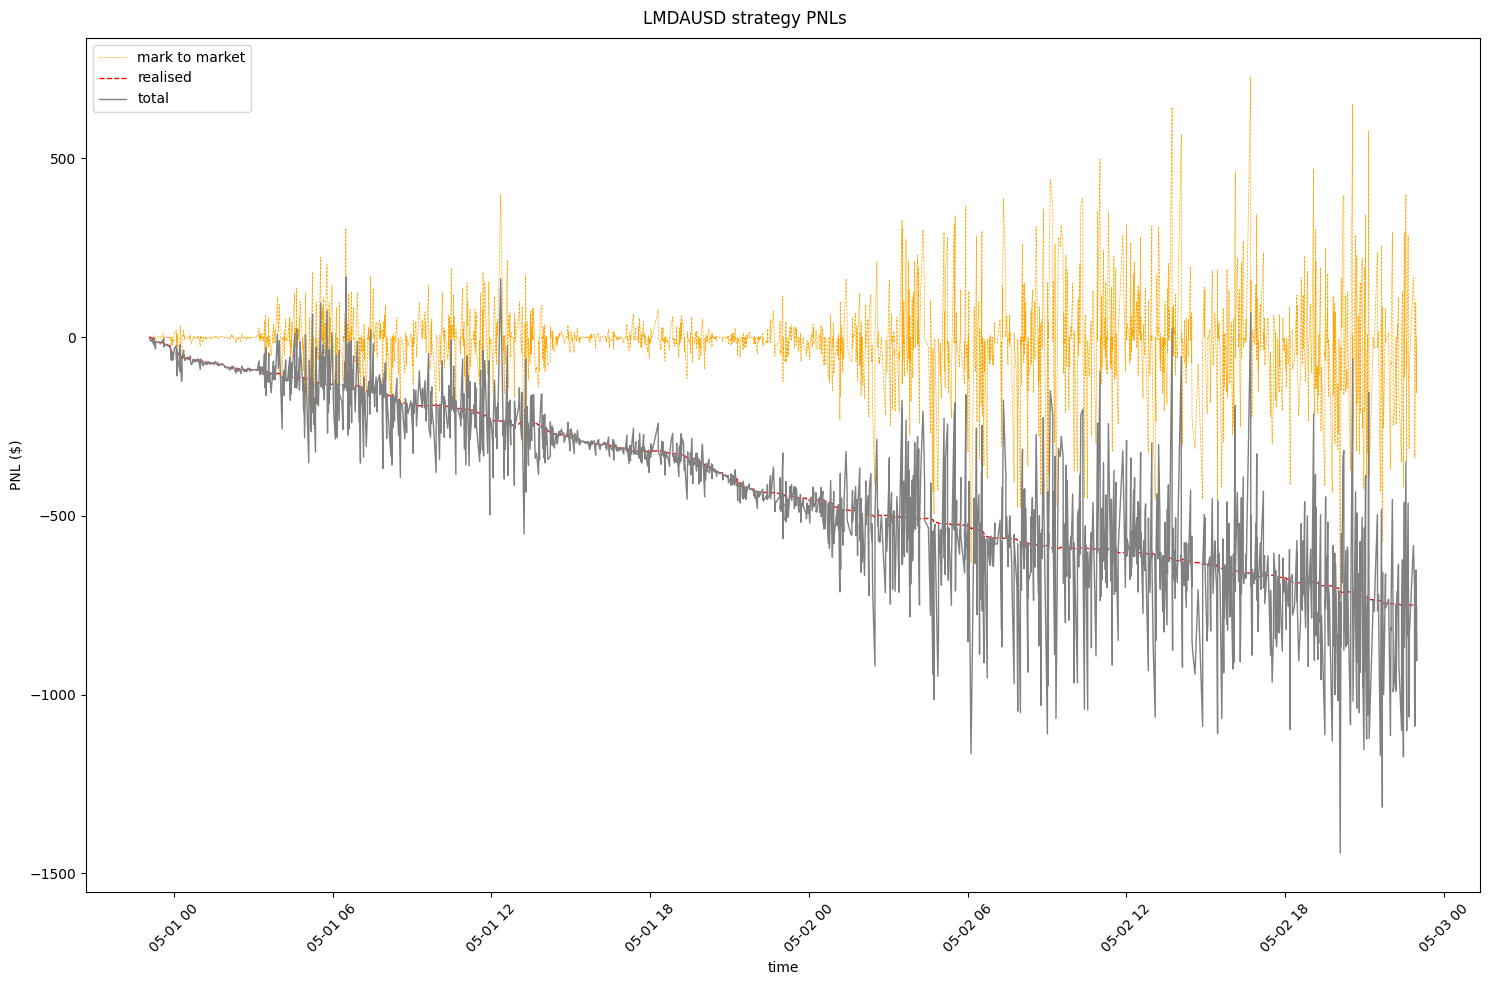

In [359]:
df = strategy_pnl(trades_data_raw[asset], mkt_data_raw[asset])
plot_pnls(df)